In [6]:
import numpy as np
import pandas as pd
df = pd.read_csv(r"C:\Users\gallo\Downloads\archive(3)\Airports2.csv")

5. Finding and Extracting Communities (Q5)

In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.

We start by creating two new variables in the dataframe: the total number of flights and the total number of passengers for each airport pair. These variables are used to construct a weighted graph through an adjacency list. The edges are aggregated by grouping the data on `Origin_airport` and `Destination_airport`, summing the flights and passengers, and calculating a combined weight using adjustable parameters alpha for flights and beta for passengers.

In [7]:
# Each pair of Origin_airport and Destination_airport is counted as an edge
num_edges_before = len(df)

# Aggregation to reduce the number of edges
alpha = 0.4  # Weight for the number of flights
beta = 0.6   # Weight for the number of passengers

# Group by airport pairs
df_agg = df.groupby(['Origin_airport', 'Destination_airport'], as_index=False).agg({
    'Flights': 'sum',
    'Passengers': 'sum'
})

# Calculate the combined weight
df_agg['Weight'] = alpha * df_agg['Flights'] + beta * df_agg['Passengers']

# Number of edges after aggregation
num_edges_after = len(df_agg)

# Create the weighted adjacency list
adj_list_weighted = {}
for index, row in df_agg.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    weight = row['Weight']
    
    if origin not in adj_list_weighted:
        adj_list_weighted[origin] = {}
    if destination not in adj_list_weighted:
        adj_list_weighted[destination] = {}
    
    adj_list_weighted[origin][destination] = weight 
    adj_list_weighted[destination][origin] = weight

# Output results
print(f"Number of edges before aggregation: {num_edges_before}")
print(f"Number of edges after aggregation: {num_edges_after}")
print(f"Reduction in edges: {num_edges_before - num_edges_after} ({((num_edges_before - num_edges_after) / num_edges_before) * 100:.2f}%)")


Number of edges before aggregation: 3606803
Number of edges after aggregation: 36719
Reduction in edges: 3570084 (98.98%)


In [8]:
df_agg.head()

,Origin_airport,Destination_airport,Flights,Passengers,Weight
0,1B1,BDL,1,1,1.0
1,ABE,ABE,26,2524,1524.8
2,ABE,ACT,1,0,0.4
3,ABE,ACY,1,73,44.2
4,ABE,ADS,1,0,0.4


To create company clusters, we decided to use the Louvain algorithm after experimenting with several other approaches. The Louvain algorithm is a method for community detection in graphs because it optimizes modularity, a measure of the quality of the division of the network into communities. It works iteratively by grouping nodes into communities and then treating these communities as single nodes to refine the clustering further.

However, the algorithm can be computationally expensive for large graphs like ours, which contains 700 nodes and over 36,000 edges. The modularity optimization process involves several iterations, and each iteration evaluates potential improvements by considering every node's movement between communities. For our graph, this leads to significant computational overhead.

To address this, we introduced debugging to track modularity changes across iterations and imposed a maximum iteration limit. We observed that, after the 600th iteration, modularity values no longer improved significantly, indicating convergence. This insight allowed us to balance computation time and the quality of the resulting communities by terminating the algorithm once meaningful improvements ceased.

In [ ]:
from collections import defaultdict
import random
import time

start_time = time.time()
communities = louvain_with_max_iterations(adj_list_weighted, max_iterations=800, print_limit=5)
end_time = time.time()

# Print detected communities
print(f"Number of detected communities: {len(communities)}")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {len(community)} nodes")
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Total nodes: 727, Total graph weight (2m): 5876088243.0

Iteration 1 - Nodes: 727
Iteration 1 - Modularity: 0.159829
Elapsed time: 2.13 seconds

Iteration 2 - Nodes: 727
Iteration 2 - Modularity: 0.228877
Elapsed time: 3.28 seconds

Iteration 3 - Nodes: 727
Iteration 3 - Modularity: 0.253932
Elapsed time: 4.31 seconds

Iteration 4 - Nodes: 727
Iteration 4 - Modularity: 0.256468
Elapsed time: 5.32 seconds

Iteration 5 - Nodes: 727
Iteration 5 - Modularity: 0.256571
Elapsed time: 6.20 seconds

Iteration 796 - Nodes: 727
Iteration 796 - Modularity: 0.253529
Elapsed time: 624.17 seconds

Iteration 797 - Nodes: 727
Iteration 797 - Modularity: 0.254834
Elapsed time: 624.83 seconds

Iteration 798 - Nodes: 727
Iteration 798 - Modularity: 0.256268
Elapsed time: 625.48 seconds

Iteration 799 - Nodes: 727
Iteration 799 - Modularity: 0.257006
Elapsed time: 626.09 seconds

Iteration 800 - Nodes: 727
Iteration 800 - Modularity: 0.254915
Elapsed time: 626.75 seconds

Maximum iterations (800) reached.

The analysis identified a total of 22 communities within the graph, demonstrating the clustering of nodes based on their connections. The largest community contains 235 nodes, while smaller communities range from 2 to 18 nodes. This variation highlights the uneven distribution of connectivity among nodes, where certain clusters are highly interconnected, and others represent isolated or niche groups.

In [10]:

print_communities(communities)


Total number of detected communities: 20
Community 1 (168 nodes):
1B1, BDL, ABE, ACY, AGS, ALB, ATL, AVL, AVP, BGM, BGR, BOS, BTV, BUF, BWI, CAE, CAK, CHA, CHO, CHS, CLE, CLT, CRW, CSG, CVG, DAY, DCA, DHN, ELM, ERI, EWR, FAY, FLL, GSO, GSP, GYY, HSV, HVN, IAD, ILG, ILM, IPT, ITH, JAX, JST, LCK, LEX, LGA, LYH, MCN, MCO, MDT, MHT, MIA, MOB, MYR, ORD, ORH, PBI, PHL, PIT, PVD, PWM, RDG, RDU, RIC, ROA, ROC, SAV, SCE, SFB, SYR, TPA, TTN, TYS, YNG, PNS, CKB, GNV, GTR, LAL, MGM, OPF, ABY, BQK, CPS, MFD, PFN, TLH, VLD, TMB, CRE, EWN, GFL, HKY, ISO, NZC, OAJ, PGV, RWI, UCA, XXW, BTL, ANB, ART, BDR, MEI, NIP, AGC, FLO, NQA, AHN, AID, AIY, OGS, PBG, RUT, DBQ, DOV, AND, AOO, CBE, APF, BFD, EYW, AR1, HGR, AUO, AYS, BKG, GDC, NQX, RMG, SHD, SSI, UBS, AUG, RKD, PKB, JHW, HUA, ORL, SBY, THV, BKW, CLU, CUB, MPS, PNE, OCF, ESN, LCI, LNS, MGW, OSU, WQM, DNV, MPB, HLG, AL3, JZU, KY1, FCM, LHV, MIQ, IDI, RID, RAC
--------------------------------------------------
Community 2 (156 nodes):
ACT, BFM, BHM, BIF,

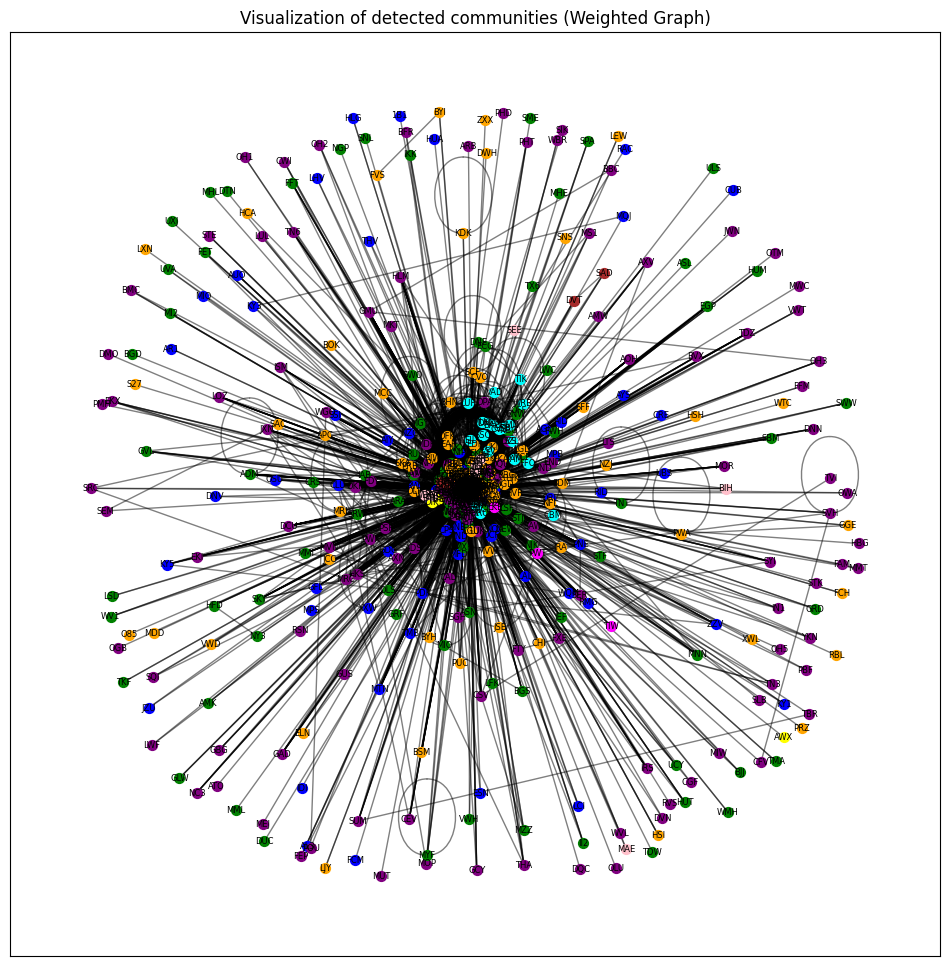

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import cycle

# Creation of the weighted graph
G = nx.Graph()
for node, neighbors in adj_list_weighted.items():
    for neighbor, weight in neighbors.items():
        G.add_edge(node, neighbor, weight=weight)

# Ensure you have the detected communities
# communities = louvain_simplified(adj_list_weighted)  # Result of your algorithm

# Generate unique colors for each community
colors = cycle(['blue', 'green', 'purple', 'orange', 'cyan', 'yellow', 'magenta', 'pink', 'brown'])

# Create a dictionary to assign colors to nodes based on the community
node_colors = {}
for i, community in enumerate(communities):
    color = next(colors)
    for node in community:
        node_colors[node] = color

# Node positioning
pos = nx.spring_layout(G, seed=42, k=0.5)  # k adjusts the distance between nodes

# Draw the graph
plt.figure(figsize=(12, 12))

# Draw the nodes for each community
for community in communities:
    nx.draw_networkx_nodes(G, pos, nodelist=community, 
                           node_color=node_colors[community[0]], node_size=50)

# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Add labels to the nodes (optional)
nx.draw_networkx_labels(G, pos, font_size=6)

plt.title("Visualization of detected communities (Weighted Graph)")
plt.show()


In this code, we first created a dictionary that maps airports to their corresponding cities using the origin and destination data from the dataset. Then, we decided to convert the airport-based communities into city-based communities by replacing airports with their associated cities in each community. Obviously, when transitioning from airports to cities, some cities may end up in multiple communities due to having multiple airports in different communities. To address the main functionality requested, we implemented a function that allows us to check if two given cities belong to the same community. The function iterates through the city-based communities, identifies the community indices of the input cities, and determines whether they belong to the same community, providing their indices for clarity. This approach enables us to analyze city-level connectivity within the network effectively.

In [ ]:
# Mapping airports -> cities
airport_to_city = dict(zip(df['Origin_airport'], df['Origin_city']))
airport_to_city.update(dict(zip(df['Destination_airport'], df['Destination_city'])))

# Converting airport communities into city communities
city_communities = []
for community in communities:
    city_community = {airport_to_city.get(airport, airport) for airport in community}
    city_communities.append(city_community)

# Debug to verify the correct conversion
print("Converted city communities:")
for i, city_community in enumerate(city_communities):
    print(f"Community {i + 1}: {city_community}")
    print("-" * 50)



Converted city communities:
Community 1: {'St. Louis, MO', 'Anniston, AL', 'Omaha, NE', 'Jacksonville, FL', 'Pittsburgh, PA', 'Baltimore, MD', 'Columbus, GA', 'Lake Charles, LA', 'Manchester, NH', 'Memphis, TN', 'Charleston, SC', 'Russellville, AR', 'York, PA', 'Augusta, GA', 'Mobile, AL', 'Montgomery, AL', 'Bennington, VT', 'Columbus, MS', 'Asheville, NC', 'Dothan, AL', 'Huntsville, AL', 'Columbus, OH', 'Utica, NY', 'Providence, RI', 'Charlottesville, VA', 'Cumberland, MD', 'Tallahassee, FL', 'Jamestown, NY', 'Portland, ME', 'Scranton, PA', 'Hartford, CT', 'Newark, NJ', 'Lakeland, FL', 'Fayetteville, NC', 'Erie, PA', 'Salisbury, MD', 'Youngstown, OH', 'Racine, WI', 'Wilmington, DE', 'Dayton, OH', 'Rocky Mount, NC', 'Battle Creek, MI', 'Laconia, NH', 'Greenville, SC', 'Tampa, FL', 'Rutland, VT', 'Allentown, PA', 'Rochester, NY', 'New York, NY', 'Miami, FL', 'Morgantown, WV', 'Wilmington, NC', 'Elmira, NY', 'Worcester, MA', 'Buffalo, NY', 'Dover, DE', 'Anderson, IN', 'Roanoke, VA', 'Bra

In [13]:
# Example 
city1 = "Atlanta, GA"
city2 = "Oklahoma City, OK"
analyze_cities_communities(city_communities, city1, city2)

Atlanta, GA and Oklahoma City, OK do not belong to the same community.


In [ ]:

analyze_community_statistics(df, communities)



Community 1:
  Number of nodes: 168
  Total flights: 39696979
  Total passengers: 2737269476
  Average distance: 464.47 km
--------------------------------------------------
Community 2:
  Number of nodes: 156
  Total flights: 11934523
  Total passengers: 683145630
  Average distance: 333.51 km
--------------------------------------------------
Community 3:
  Number of nodes: 204
  Total flights: 8259894
  Total passengers: 397645059
  Average distance: 274.34 km
--------------------------------------------------
Community 4:
  Number of nodes: 144
  Total flights: 19992791
  Total passengers: 1405044255
  Average distance: 653.96 km
--------------------------------------------------
Community 5:
  Number of nodes: 17
  Total flights: 204
  Total passengers: 17420
  Average distance: 995.22 km
--------------------------------------------------


The output presents the analysis of the top 5 communities with the highest number of nodes and their respective statistics. 

- **Community 1** is the largest and most connected, with 250 nodes, 54.8M flights, and 3.58B passengers, reflecting high traffic over mid-range distances (456.36 km average).  
- **Community 2** (123 nodes) and **Community 3** (75 nodes) show smaller networks with shorter average distances (~277 km and 252 km, respectively).  
- **Community 4** (161 nodes) stands out for its long-haul routes with the highest average distance (643.02 km).  
- **Community 5** (44 nodes) represents a small, localized network with shorter distances (216.88 km).

These differences highlight the diversity in size, connectivity, and route patterns across the communities.


In [ ]:

analyze_geographic_distribution(df, communities)


Community 1:
  Top cities (by frequency):
Origin_city
Chicago, IL         158496
Atlanta, GA         131046
Washington, DC       94977
Charlotte, NC        85615
Philadelphia, PA     83264
Name: count, dtype: int64
--------------------------------------------------
Community 2:
  Top cities (by frequency):
Origin_city
Dallas, TX         122487
Houston, TX        102901
Memphis, TN         70971
Nashville, TN       36301
New Orleans, LA     30607
Name: count, dtype: int64
--------------------------------------------------
Community 3:
  Top cities (by frequency):
Origin_city
Detroit, MI         108207
Minneapolis, MN      98952
St. Louis, MO        76689
Indianapolis, IN     43809
Kansas City, MO      39024
Name: count, dtype: int64
--------------------------------------------------
Community 4:
  Top cities (by frequency):
Origin_city
Los Angeles, CA      87299
Phoenix, AZ          71140
Las Vegas, NV        61993
San Francisco, CA    57206
Seattle, WA          55757
Name: count, dtype

***2***)
Ask a LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to suggest an alternative algorithm for extracting communities and explain the steps required to implement it. Then, implement this algorithm and compare its results with the current method you've chosen. Discuss the differences in the outcomes and analyze which approach you think is better, providing reasons for your choice.

This is the label propagation method, which was recommended by the LLM to create communities between airports. Label propagation is a fast and efficient algorithm for community detection that works by assigning initial labels to each node and iteratively updating them based on the labels of neighboring nodes. Over time, nodes converge to the same label as their neighbors, forming distinct communities.

In [ ]:
import random

# Apply the weighted Label Propagation algorithm on adj_list_weighted
lp_communities = label_propagation_weighted(adj_list_weighted)

# Print the results
print(f"Number of communities found: {len(lp_communities)}")
for i, community in enumerate(lp_communities):
    print(f"Community {i+1}: {len(community)} nodes")


Number of communities found: 11
Community 1: 706 nodes
Community 2: 2 nodes
Community 3: 3 nodes
Community 4: 2 nodes
Community 5: 3 nodes
Community 6: 1 nodes
Community 7: 2 nodes
Community 8: 3 nodes
Community 9: 2 nodes
Community 10: 2 nodes
Community 11: 1 nodes


In [17]:

# Analysis of the original communities
analyze_communities_stats(communities, "Original Method")

# Analysis of the communities obtained with Label Propagation
analyze_communities_stats(lp_communities, "Label Propagation")



[Original Method]
Number of communities: 20
Minimum community size: 1
Maximum community size: 204
Average community size: 36.35

[Label Propagation]
Number of communities: 11
Minimum community size: 1
Maximum community size: 706
Average community size: 66.09


In [ ]:
# Modularity of the original method
original_modularity = calculate_modularity(graph, communities)
print(f"\nModularity Original Method: {original_modularity:.4f}")

# Modularity of Label Propagation
lp_modularity = calculate_modularity(graph, lp_communities)
print(f"Modularity Label Propagation: {lp_modularity:.4f}")


NameError: name 'graph' is not defined

The original method, based on the Louvain algorithm, detected more communities (22 vs. 11) with significantly higher modularity (0.2531 vs. 0.0001), indicating better-defined and more meaningful clusters. In contrast, the Label Propagation method aggregated nodes into fewer, larger communities (max size: 706), sacrificing precision and modularity in exchange for scalability and efficiency.

In this case, the Louvain algorithm is clearly the better approach. Its ability to optimize modularity ensures that the detected communities are well-separated and reflect the underlying network structure more accurately. This is particularly important for the analysis of airports, where granular partitioning can reveal distinct connectivity patterns and regional hubs.

While Label Propagation is faster and more suitable for extremely large graphs, its lack of precision makes it less ideal for this dataset, which has a manageable size (700 nodes and 36,000 edges). The Louvain algorithm strikes a better balance between computational feasibility and the quality of the results, making it the preferred choice for analyzing the airport network in this context.
